In [2]:
import pandas as pd
import numpy as np
import calendar
import datetime
import scipy.stats as sps
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data = pd.read_csv('forestfires.csv')

### Преобразование данных.

Заменим месяцы на индикаторы летнего месяца:

In [6]:
def num_to_month(st):
    if st == 'aug' or st == 'jun' or st == 'jul':
        return 1
    else:
        return 0
data['month'] = map(num_to_month, data['month'])

Удалим данные о дне недели:

In [7]:
data.drop('day', axis=1, inplace=True)

Добавим единичый признак для свободного коэффициента:

In [8]:
data['c'] = 1

In [9]:
Mtrx = np.matrix(data.as_matrix())

### Построение регрессионной модели.

Разобьем матрицу на две части в отношении 7:3

In [10]:
np.random.shuffle(Mtrx)

In [11]:
Area = Mtrx[:, [11]]
Data = np.delete(Mtrx, 11, axis=1)

In [12]:
X = Area[:362]
Z = Data[:362]
X_test = Area[362:]
Z_test = Data[362:]

Построим методом наименьших квадратов линейную функцию от 12 аргументов, которая будет выражать координату "area" через другие данные. Оценка параметров этой функции имеет вид $\widehat{\theta} = (Z^T Z)^{-1}Z^T X$.

In [13]:
Theta = (Z.T * Z).I * Z.T * X

In [14]:
np.std(X_test - Z_test * Theta)

26.704323682888866

Так как данные "area" распределены около нуля, воспользуемся логарифмическим <b>преобразованием</b> $f(x) = log(x + 1)$ этих данных.

In [15]:
c = 1

In [16]:
X_log = np.log(X + c)
X_test_log = np.log(X_test + c)

In [17]:
Theta = (Z.T * Z).I * Z.T * X_log

Среднеквадратичная ошибка для преобразованных значений:

In [18]:
np.std(X_test_log - Z_test * Theta)

1.3669592432563265

Среднеквадратичная ошибка для значений

In [19]:
np.std(np.exp(X_test_log) - c - Z_test * Theta)

21.873938655297547

Для разных разбиейний выборки посмотрим на ошибку. Будем рассматривать только разбиения, для которых ранг матрицы обучающей выборка не меньше 12 (имеем матрицу 362x12).

Для произвольного разбиения данных рассмотрим поводение среднеквадратичной ошибки при увелечении коэффициента $c$. 

In [75]:
np.random.shuffle(Mtrx)
std_array = np.array([])
for c in np.arange(1, 100):    
    Area = Mtrx[:, [11]]
    Data = np.delete(Mtrx, 11, axis=1)
    X = Area[:362]
    Z = Data[:362]    
    #print np.linalg.matrix_rank(Z)
    if np.linalg.matrix_rank(Z) < 12:
        c -= 1
        continue
    X_test = Area[362:]
    Z_test = Data[362:]   
    
    X_log = np.log(X + c)
    X_test_log = np.log(X_test + c)
    Theta = (Z.T * Z).I * Z.T * X_log
    std_array = np.append(std_array, np.std(np.exp(X_test_log) - c - Z_test * Theta))

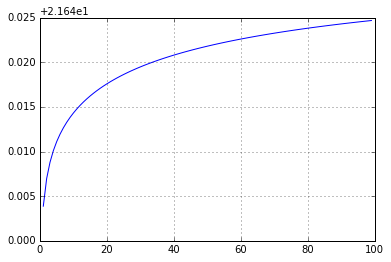

In [76]:
x = np.arange(1, 100)
plt.plot(x, std_array)
plt.ylim(0, 1000000000)
plt.grid()

Видим, что с увеличеним коэффициента $c$ среднеквадратичная ошибка увеличивается. 

$c = 1$, 1000 разбиений:

In [29]:
c = 1
std_array = np.array([])
for i in range(1000):
    np.random.shuffle(Mtrx)
    Area = Mtrx[:, [11]]
    Data = np.delete(Mtrx, 11, axis=1)
    X = Area[:362]
    Z = Data[:362]    
    #print np.linalg.matrix_rank(Z)
    if np.linalg.matrix_rank(Z) < 12:
        continue
    X_test = Area[362:]
    Z_test = Data[362:]   
    
    X_log = np.log(X + c)
    X_test_log = np.log(X_test + c)
    Theta = (Z.T * Z).I * Z.T * X_log
    std_array = np.append(std_array, np.std(np.exp(X_test_log) - c - Z_test * Theta))

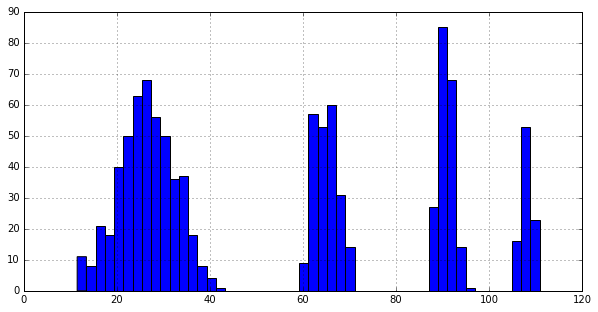

In [30]:
plt.figure(figsize=(10, 5))
plt.hist(std_array, 50)
plt.grid()
plt.show()

Видим, что для наибольшего числа разбиений среднеквадратичная ошибка от 20 до 40.